# Setting

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import os
from collections import deque
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
os.chdir('drive/My Drive/Colab Notebooks/Numeraxial/data_cleaned')
path = os.getcwd()
dir_list = os.listdir(path) 
print("Files and directories in '", path, "' :")  
dir_list.sort()
print(dir_list)

Files and directories in ' /content/drive/My Drive/Colab Notebooks/Numeraxial/data_cleaned ' :
['AAPL.pkl', 'AXP.pkl', 'BA.pkl', 'CAT.pkl', 'CSCO.pkl', 'CVX.pkl', 'DIS.pkl', 'GE.pkl', 'GS.pkl', 'HD.pkl', 'IBM.pkl', 'INTC.pkl', 'JNJ.pkl', 'JPM.pkl', 'KO.pkl', 'MCD.pkl', 'MMM.pkl', 'MRK.pkl', 'MSFT.pkl', 'NKE.pkl', 'PFE.pkl', 'PG.pkl', 'TRV.pkl', 'UNH.pkl', 'UTX.pkl', 'V.pkl', 'VZ.pkl', 'WMT.pkl', 'XOM.pkl', 'tune_optimizer', 'untitled_project']


# Preprocessing

In [87]:
df = pd.read_pickle(np.random.choice(dir_list, 5)[0])
fmt = "%Y-%m-%d %H:%M:%S"
df.index = df.index.strftime(fmt)
df.reset_index(inplace=True)
# df['SMA100'] = df['Close'].rolling(window = 100).mean()
df.columns

Index([  'Date', 'Symbol',   'Open',   'High',    'Low',  'Close', 'Volume',
              0,        1,        2,
       ...
             90,       91,       92,       93,       94,       95,       96,
             97,       98,       99],
      dtype='object', length=107)

In [231]:
def up_or_down(dfin):
  now = dfin['Close']
  future = dfin['Future']
  if float(now) > float(future):
    return 0
  else:
    return 1

df = pd.read_pickle('PG.pkl')
fmt = "%Y-%m-%d %H:%M:%S"
df.index = df.index.strftime(fmt)
df.reset_index(inplace=True)
df = df.iloc[:,:7]
df['Future'] = df['Close'].shift(-1)
df['SMA100'] = df['Close'].rolling(window = 100).mean()
df['Tartget'] = df.apply(up_or_down, axis=1)
df['Open_pch'] = df['Open'].pct_change()
df['High_pch'] = df['High'].pct_change()
df['Low_pch'] = df['Low'].pct_change()
df['Close_pch'] = df['Close'].pct_change()
df['Volume_pch'] = df['Volume'].pct_change()
df['Future_pch'] = df['Future'].pct_change()

df = df.iloc[1:,:]
df.reset_index(inplace=True)
df.drop(columns='index',inplace=True)
# df.dropna(axis=0, , inplace=True)
# df.drop(columns='Future', inplace=True)


split_time = int(df.shape[0]*.8)
df.head()

,Date,Symbol,Open,High,Low,Close,Volume,Future,SMA100,Tartget,Open_pch,High_pch,Low_pch,Close_pch,Volume_pch,Future_pch
0,2017-07-03 12:00:00,PG,87.79,87.79,87.72,87.74,20186,87.78,NaN,1,0.000912,0.000342,0.000114,-0.000114,-0.573343,0.000456
1,2017-07-03 12:15:00,PG,87.71,87.80,87.71,87.78,99721,87.87,NaN,1,-0.000911,0.000114,-0.000114,0.000456,3.940107,0.001025
2,2017-07-03 12:30:00,PG,87.83,87.88,87.83,87.87,79955,87.87,NaN,1,0.001368,0.000911,0.001368,0.001025,-0.198213,0.000000
3,2017-07-03 12:45:00,PG,87.89,87.90,87.87,87.87,95487,87.74,NaN,0,0.000683,0.000228,0.000455,0.000000,0.194259,-0.001479
4,2017-07-03 13:00:00,PG,87.75,87.75,87.74,87.74,460452,87.74,NaN,1,-0.001593,-0.001706,-0.001479,-0.001479,3.822143,0.000000


# Predicting the stock movement using LSTM

A stock movement will be predicted using the past 100-day historical features including open, high, low, close, volumn, and the percent change from previous day. If the previous closing price is less than today's closing price, the stock went up and otherwise, it went down.

First, a 100-day window of features are put together to predict if the price goes up or down. For every stock, 80% of the prices are trained and the rest will be tested for validating its model performance.

## Preprocessing data

In [10]:
def up_or_down(dfin):
  now = dfin['Close']
  future = dfin['Future']
  if float(now) > float(future):
    return 0
  else:
    return 1

df = df[df.columns[2:7]]
df['Future'] = df['Close'].shift(-1)
df['Close_pct_change'] = (df['Future'] - df['Close'])/df['Close']

df['Target'] = df.apply(up_or_down, axis=1)
df.dropna(axis=0, inplace=True)
df.drop(columns='Future', inplace=True)
df

,Open,High,Low,Close,Volume,Close_pct_change,Target
0,107.49,107.63,107.02,107.10,132737,0.002334,1
1,106.98,107.40,106.98,107.35,79673,0.002329,1
2,107.40,107.67,107.39,107.60,72395,-0.001115,0
3,107.47,107.60,107.37,107.48,47313,0.002977,1
4,107.68,107.84,107.64,107.80,35516,-0.004360,0
...,...,...,...,...,...,...,...
7199,155.26,155.26,155.22,155.22,500,0.000580,1
7200,154.82,155.39,154.81,155.31,62144,-0.000129,0
7201,155.16,155.34,155.12,155.29,52984,-0.001996,0
7202,155.02,155.07,154.83,154.98,108079,-0.002194,0


In [30]:
x = np.array(df.iloc[:,:-1], dtype=np.float32)
scaler = MinMaxScaler()
scaler.fit(x)
x_trans = scaler.transform(x)
x_target = df['Target']
df = pd.DataFrame(x_trans,columns=df.columns[:-1])
df['Target'] = x_target
df
# xy = np.concatenate((xy_pr, xy[:,5:]), axis = 1)
# print(xy)

,Open,High,Low,Close,Volume,Close_pct_change,Target
0,0.032988,0.034969,0.027766,0.027653,0.029638,0.478101,1
1,0.025641,0.031659,0.027187,0.031273,0.017781,0.478057,1
2,0.031691,0.035545,0.033116,0.034892,0.016155,0.450275,0
3,0.032700,0.034537,0.032827,0.033155,0.010550,0.483288,1
4,0.035725,0.037991,0.036732,0.037788,0.007914,0.424101,0
...,...,...,...,...,...,...,...
7199,0.721118,0.720391,0.724801,0.724338,0.000089,0.463948,1
7200,0.714780,0.722262,0.718872,0.725641,0.013864,0.458232,0
7201,0.719677,0.721542,0.723355,0.725351,0.011817,0.443168,0
7202,0.717661,0.717657,0.719161,0.720863,0.024128,0.441574,0


In [43]:
window_size = 100
batch_size = 300
split_time = int(df.shape[0]*.8)

seq = deque(maxlen = window_size)
seq_window = []
for val in df.values:
  seq.append([n for n in val[:-1]])
  if len(seq) == window_size:
    seq_window.append([np.array(seq), val[-1]])

random.shuffle(seq_window)

x_data = []
y_data = []
for seq, target in seq_window:
  x_data.append(seq)
  y_data.append(target)

# x_data = np.array(x_data)
print('X data:', len(x_data))
print('Y data:', len(y_data))
print('Y data value counts')
print(pd.Series(y_data).value_counts())

x_train = x_data[:split_time]
y_train = y_data[:split_time]
x_valid = x_data[split_time:]
y_valid = y_data[split_time:]
print('=====After splitting=====')
print('X train:', len(x_train))
print('X valid:', len(x_valid))
print('Y train value counts')
print(pd.Series(y_train).value_counts())
print('Y valid value counts')
print(pd.Series(y_valid).value_counts())


x_data =np.array(x_data).reshape(-1,window_size,6)
x_train = np.array(x_train).reshape(-1,window_size,6)
x_valid = np.array(x_valid).reshape(-1,window_size,6)
y_data = np.array(y_data).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)
y_valid = np.array(y_valid).reshape(-1,1)

X data: 7105
Y data: 7105
Y data value counts
1.0    3794
0.0    3311
dtype: int64
=====After splitting=====
X train: 5763
X valid: 1342
Y train value counts
1.0    3068
0.0    2695
dtype: int64
Y valid value counts
1.0    726
0.0    616
dtype: int64


## Training data

In [44]:
model = tf.keras.Sequential([
  # tf.keras.layers.SimpleRNN(50, input_shape=(x_train.shape[1:]), return_sequences=True, activation='relu'),
  # tf.keras.layers.SimpleRNN(50, activation='relu'),
  # tf.compat.v1.keras.layers.CuDNNLSTM(128, input_shape=(x_train.shape[1:]), return_sequences=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, input_shape=(x_train.shape[1:]),return_sequences=True)),  
  tf.keras.layers.Dropout(.3),
  tf.keras.layers.BatchNormalization(),

  # tf.compat.v1.keras.layers.CuDNNLSTM(128),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dropout(.3),
  tf.keras.layers.BatchNormalization(),

  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(.3),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(.3),
  tf.keras.layers.Dense(2, activation='softmax')#,
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size = batch_size, validation_data=(x_valid, y_valid), epochs=100)

Epoch 1/100
20/20 [==============================] - 4s 181ms/step - loss: 0.9290 - accuracy: 0.5098 - val_loss: 0.6940 - val_accuracy: 0.5395
Epoch 2/100
20/20 [==============================] - 2s 93ms/step - loss: 0.9281 - accuracy: 0.5077 - val_loss: 0.6937 - val_accuracy: 0.5410
Epoch 3/100
20/20 [==============================] - 2s 94ms/step - loss: 0.9231 - accuracy: 0.5043 - val_loss: 0.6937 - val_accuracy: 0.5410
Epoch 4/100
20/20 [==============================] - 2s 94ms/step - loss: 0.9253 - accuracy: 0.4942 - val_loss: 0.6939 - val_accuracy: 0.5410
Epoch 5/100
20/20 [==============================] - 2s 91ms/step - loss: 0.9219 - accuracy: 0.5167 - val_loss: 0.6941 - val_accuracy: 0.5410
Epoch 6/100
20/20 [==============================] - 2s 91ms/step - loss: 0.9275 - accuracy: 0.5237 - val_loss: 0.6945 - val_accuracy: 0.5410
Epoch 7/100
20/20 [==============================] - 2s 92ms/step - loss: 0.9213 - accuracy: 0.5096 - val_loss: 0.6950 - val_accuracy: 0.5410
Epoch

## Results

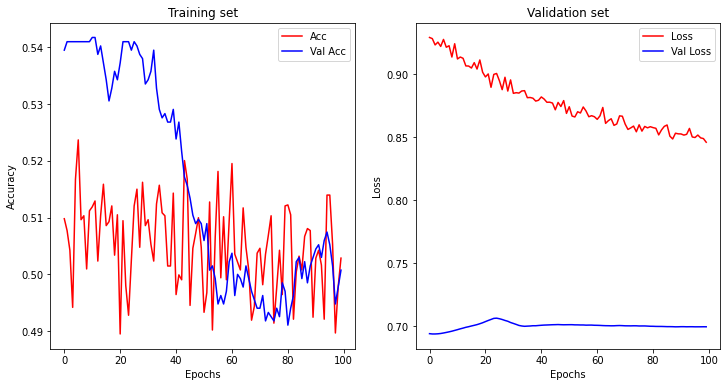

In [45]:
acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
epochs=range(len(loss))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label = 'Acc')
plt.plot(epochs, val_acc, 'b', label = 'Val Acc')
plt.title('Training set')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label = 'Loss')
plt.plot(epochs, val_loss, 'b', label = 'Val Loss')
plt.title('Validation set')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


Likewise, the accuracy is around 50%, which means it acts like a random walk. Further study is required to improve this model to boost up the accuracy.

# Predicting a closing price using RNN

A closing price will be predicted for a deep neural network model and compared with 100-day SMA for their efficiencies.

First, a 100-day window of prices are put together to estimate the next price and the window of prices are adjusted corresponding to prices that one wants to estimate. For every stock, 80% of the prices are trained and the rest will be tested for validating its model performance.

## Preprocessing data

In [0]:
split_time = int(df.shape[0]*.8)
time = df.index.values
series = df['Close'].values
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 100
batch_size = 300
shuffle_buffer_size = 1000

In [37]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(3).prefetch(1)
for x,y in dataset:
  print('x={}, y={}'.format(x.numpy(), y.numpy()))

x=[[0 1 2]
 [1 2 3]
 [2 3 4]], y=[[3]
 [4]
 [5]]
x=[[3 4 5]
 [4 5 6]
 [5 6 7]], y=[[6]
 [7]
 [8]]
x=[[6 7 8]], y=[[9]]


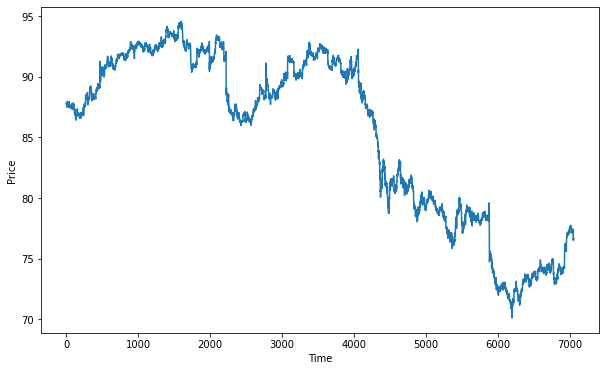

In [38]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(False)


plt.figure(figsize=(10,6))
plot_series(time,series)

A dataset is divided into the train, test test beforehand. A DNN has 3 hidden layers in which there are 100, 50, and 10 neurons for layers respectively and the RELU activation function is used. The wieghts are initialized to avoid vanishing the gradients due to the backpropagation.

### Why Initialize Weights


The aim of weight initialization is to prevent layer activation outputs from exploding or vanishing during the course of a forward pass through a deep neural network. If either occurs, loss gradients will either be too large or too small to flow backwards beneficially, and the network will take longer to converge, if it is even able to do so at all.

When the matrix multiplication, several layers in deep neural nets, the product of this multiplication at one layer becomes the inputs of the subsequent layer, and so on and so forth. Numerous matrix multiplication may lead to vanishing/exploding gradients so one of weights initialization methods is applied(e.g., Xavier's)

### Sequence bias

Sequence bias is when the order of things can impact the selection of things. For example, if I were to ask you your favorite TV show, and listed "Game of Thrones", "Killing Eve", "Travellers" and "Doctor Who" in that order, you're probably more likely to select 'Game of Thrones' as you are familiar with it, and it's the first thing you see. Even if it is equal to the other TV shows. So, when training data in a dataset, we don't want the sequence to impact the training in a similar way, so it's good to shuffle them up.

## Training data

In [39]:
tf.random.set_seed(1000)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='relu'),
  tf.keras.layers.SimpleRNN(50, activation='relu'),
  tf.keras.layers.Dense(1)#,
  # tf.keras.layers.Lambda(lambda x: x * 100.0) # act func: tan h from -1 to 1 so implemented
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
19/19 [==============================] - 2s 107ms/step - loss: 105.0721 - mae: 105.5721 - lr: 1.0000e-08
Epoch 2/100
19/19 [==============================] - 2s 106ms/step - loss: 104.8619 - mae: 105.3619 - lr: 1.1220e-08
Epoch 3/100
19/19 [==============================] - 2s 108ms/step - loss: 104.5859 - mae: 105.0859 - lr: 1.2589e-08
Epoch 4/100
19/19 [==============================] - 2s 110ms/step - loss: 104.2720 - mae: 104.7720 - lr: 1.4125e-08
Epoch 5/100
19/19 [==============================] - 2s 108ms/step - loss: 103.9207 - mae: 104.4207 - lr: 1.5849e-08
Epoch 6/100
19/19 [==============================] - 2s 105ms/step - loss: 103.5286 - mae: 104.0286 - lr: 1.7783e-08
Epoch 7/100
19/19 [==============================] - 2s 107ms/step - loss: 103.0913 - mae: 103.5913 - lr: 1.9953e-08
Epoch 8/100
19/19 [==============================] - 2s 105ms/step - loss: 102.6038 - mae: 103.1038 - lr: 2.2387e-08
Epoch 9/100
19/19 [==============================] - 2s 105ms/st

(1e-07, 0.0001, 0.0, 60.0)

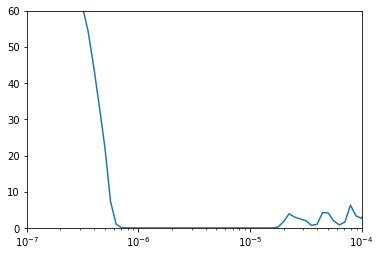

In [44]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7,1e-4,0,60])

In [45]:
tf.random.set_seed(1000)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='relu'),
  tf.keras.layers.SimpleRNN(50, activation = 'relu'),
  tf.keras.layers.Dense(1)# ,
  # tf.keras.layers.Lambda(lambda x: x * 800.0) # tan h from -1 to 1 so implemented
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=20)

Epoch 1/20
19/19 [==============================] - 2s 102ms/step - loss: 100.3428 - mae: 100.8428
Epoch 2/20
19/19 [==============================] - 2s 102ms/step - loss: 85.3113 - mae: 85.8113
Epoch 3/20
19/19 [==============================] - 2s 103ms/step - loss: 69.7603 - mae: 70.2603
Epoch 4/20
19/19 [==============================] - 2s 104ms/step - loss: 51.1109 - mae: 51.6109
Epoch 5/20
19/19 [==============================] - 2s 103ms/step - loss: 28.1861 - mae: 28.6861
Epoch 6/20
19/19 [==============================] - 2s 109ms/step - loss: 6.0378 - mae: 6.5359
Epoch 7/20
19/19 [==============================] - 2s 116ms/step - loss: 0.9901 - mae: 1.4309
Epoch 8/20
19/19 [==============================] - 2s 113ms/step - loss: 0.1885 - mae: 0.5222
Epoch 9/20
19/19 [==============================] - 2s 108ms/step - loss: 0.0436 - mae: 0.2348
Epoch 10/20
19/19 [==============================] - 2s 107ms/step - loss: 0.0243 - mae: 0.1550
Epoch 11/20
19/19 [==================

## Results

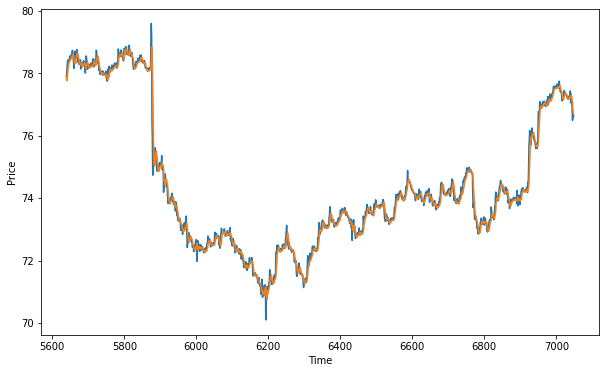

In [46]:
forecast = []
for time in range(len(df) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

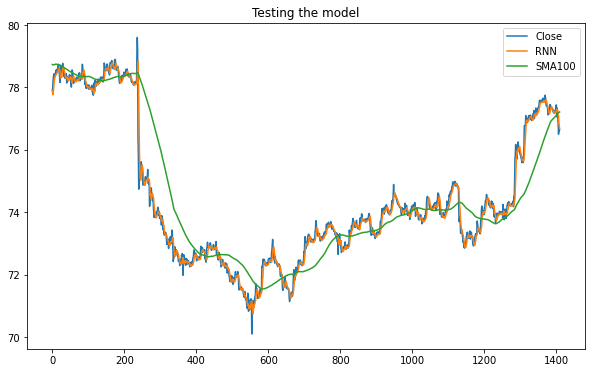

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(x_valid, label ='Close')
plt.plot(np.array(forecast).reshape(-1), label = 'RNN')
plt.plot(df['SMA100'].values[split_time:], label = 'SMA100')
plt.title('Testing the model')
plt.legend()

0.05349698


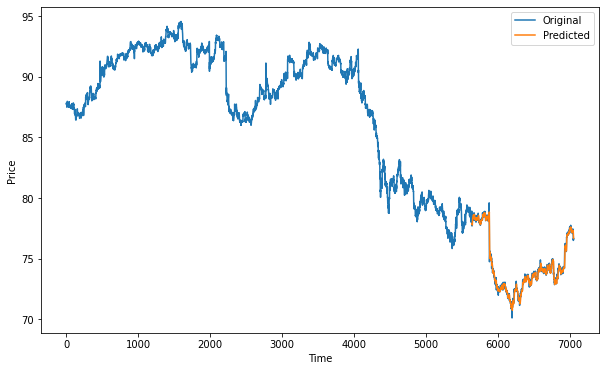

In [48]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
plt.figure(figsize=(10, 6))
plt.plot(series)
plot_series(time_valid, results)
plt.legend(['Original','Predicted'])

<Figure size 432x288 with 0 Axes>

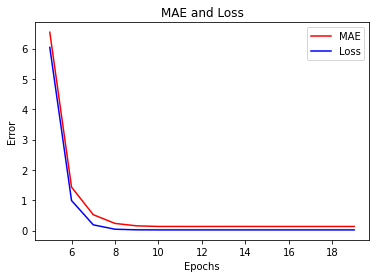

<Figure size 432x288 with 0 Axes>

In [52]:
mae=history.history['mae']
loss=history.history['loss']
epochs=range(len(loss))
plt.plot(epochs[5:], mae[5:], 'r')
plt.plot(epochs[5:], loss[5:], 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(["MAE", "Loss"])
plt.figure()

# Predicting a closing price using LSTM

In [56]:
tf.random.set_seed(1000)
np.random.seed(1000)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1)#,
  # tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

18/19 [===========================>..] - ETA: 0s - loss: 84.2340 - mae: 84.7340

KeyboardInterrupt: ignored

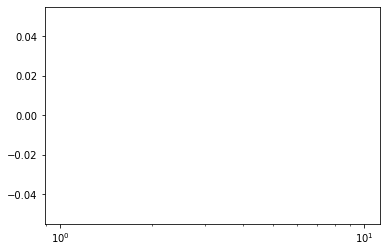

In [55]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=4e-7, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=100)

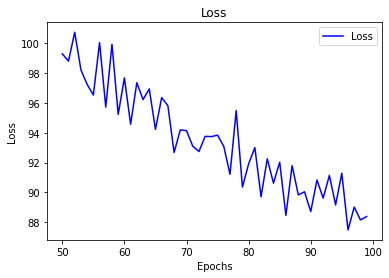

In [115]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs[50:], loss[50:], 'b')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

Still improving as the epochs get greater

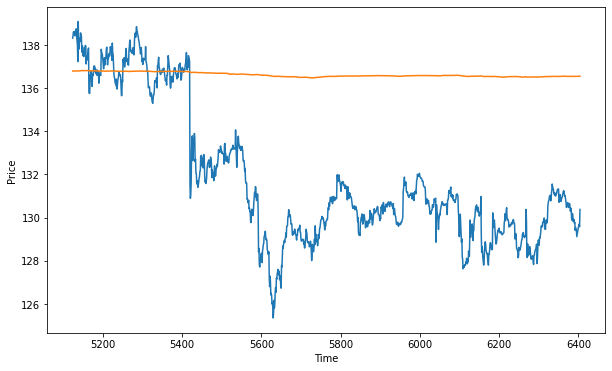

In [112]:
forecast = []
for time in range(len(df) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

32.667202


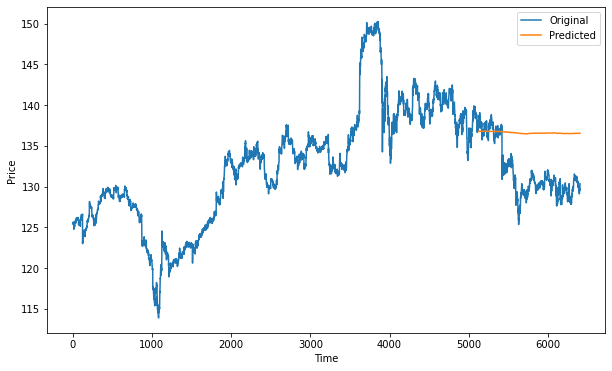

In [113]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
plt.figure(figsize=(10, 6))
plt.plot(series)
plot_series(time_valid, results)
plt.legend(['Original','Predicted'])

# Predicting a closing price using DNN


A closing price will be predicted for a deep neural network model and compared with 100-day SMA for their efficiencies.


First, a 100-day window of prices are put together to estimate the next price and the window of prices are adjusted corresponding to prices that one wants to estimate. For every stock, 80% of the prices are trained and the rest will be tested for validating its model performance.

In [0]:
tf.random.set_seed(1000)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu", kernel_initializer='glorot_normal'), 
    tf.keras.layers.Dense(50, activation="relu", kernel_initializer='glorot_normal'),
    # tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset, epochs=100)

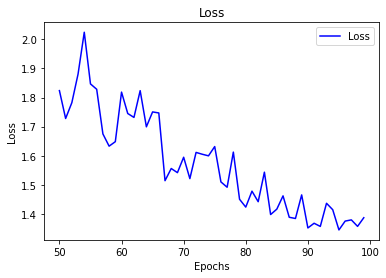

In [117]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs[50:], loss[50:], 'b')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

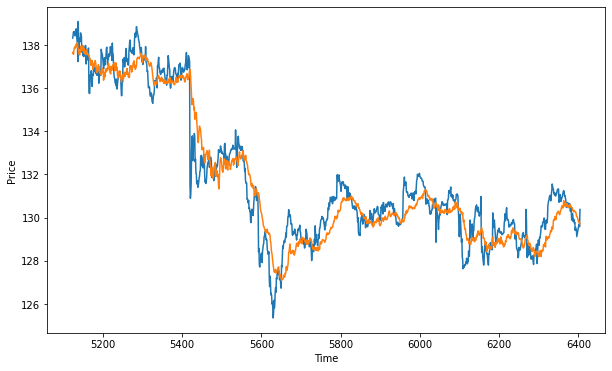

In [118]:
forecast = []
for time in range(len(df) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

0.83723885


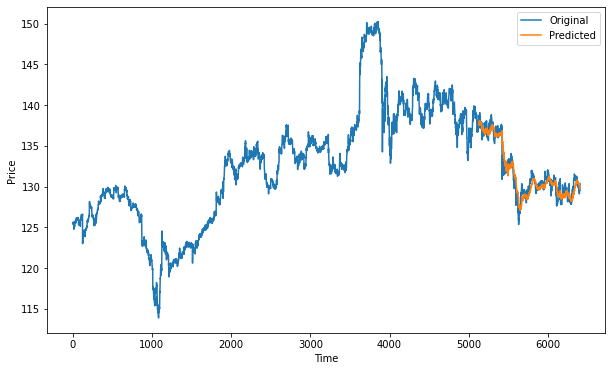

In [119]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
plt.figure(figsize=(10, 6))
plt.plot(series)
plot_series(time_valid, results)
plt.legend(['Original','Predicted'])

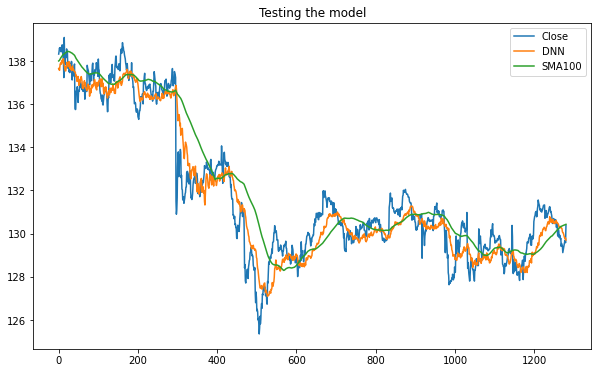

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(x_valid, label = 'Close')
plt.plot(np.array(forecast).reshape(-1), label = 'DNN')
plt.plot(df['SMA100'].values[split_time:], label = 'SMA100')
plt.title('Testing the model')
plt.legend()

## Results

Oviously, the DNN model outperforms the the simple moving average method in predicting closing prices with the mean squred error of 3.046. The price series of DNN looks over-priced than the original overall so further study should be continued to fix this.

# Normalization

In [169]:
xy = np.array(df.iloc[:,2:-1], dtype=np.float32)
scaler = MinMaxScaler()
scaler.fit(xy[:,:5])
xy_pr=scaler.transform(xy[:,:5])
xy = np.concatenate((xy_pr, xy[:,5:]), axis = 1)
print(xy)

[[0.         0.         0.00291538 ... 0.11061667 0.28565    0.18173334]
 [0.00858927 0.         0.         ... 0.305      0.027      0.085     ]
 [0.01078224 0.00516605 0.01658154 ... 0.268      0.37       0.374     ]
 ...
 [0.9448099  0.94557214 0.94515324 ... 0.342      0.489      0.297     ]
 [0.94645476 0.94483423 0.93549585 ... 0.342      0.489      0.297     ]
 [0.9371345  0.95110726 0.94023323 ... 0.16333333 0.8796667  0.269     ]]


In [170]:
# xy = np.array(df.iloc[:,1:], dtype=np.float32)
xy.shape

(9763, 105)

In [0]:
# xy = np.array(
#     [
#         [828.659973, 833.450012, 908100, 828.349976, 831.659973],
#         [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
#         [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
#         [816, 820.958984, 1008100, 815.48999, 819.23999],
#         [819.359985, 823, 1188100, 818.469971, 818.97998],
#         [819, 823, 1198100, 816, 820.450012],
#         [811.700012, 815.25, 1098100, 809.780029, 813.669983],
#         [809.51001, 816.659973, 1398100, 804.539978, 809.559998],
#     ]
# )

# def min_max_scaler(data):
#     numerator = data - np.min(data, 0)
#     denominator = np.max(data, 0) - np.min(data, 0)
#     # noise term prevents the zero division
#     return numerator / (denominator + 1e-7)# * (max-min) + min

# xy = min_max_scaler(xy)
# scaler = MinMaxScaler()
# scaler.fit(xy)
# xy=scaler.transform(xy)
print(xy[:,:5])

# '''
# [[0.99999999 0.99999999 0.         1.         1.        ]
#  [0.70548491 0.70439552 1.         0.71881782 0.83755791]
#  [0.54412549 0.50274824 0.57608696 0.606468   0.6606331 ]
#  [0.33890353 0.31368023 0.10869565 0.45989134 0.43800918]
#  [0.51436    0.42582389 0.30434783 0.58504805 0.42624401]
#  [0.49556179 0.42582389 0.31521739 0.48131134 0.49276137]
#  [0.11436064 0.         0.20652174 0.22007776 0.18597238]
#  [0.         0.07747099 0.5326087  0.         0.        ]]
# '''

[[8.28659973e+02 8.33450012e+02 9.08100000e+05 8.28349976e+02
  8.31659973e+02]
 [8.23020020e+02 8.28070007e+02 1.82810000e+06 8.21655029e+02
  8.28070007e+02]
 [8.19929993e+02 8.24400024e+02 1.43810000e+06 8.18979980e+02
  8.24159973e+02]
 [8.16000000e+02 8.20958984e+02 1.00810000e+06 8.15489990e+02
  8.19239990e+02]
 [8.19359985e+02 8.23000000e+02 1.18810000e+06 8.18469971e+02
  8.18979980e+02]
 [8.19000000e+02 8.23000000e+02 1.19810000e+06 8.16000000e+02
  8.20450012e+02]
 [8.11700012e+02 8.15250000e+02 1.09810000e+06 8.09780029e+02
  8.13669983e+02]
 [8.09510010e+02 8.16659973e+02 1.39810000e+06 8.04539978e+02
  8.09559998e+02]]


In [171]:
print(int(len(xy) * .9))
print(len(xy))

8786
9763


In [0]:
split_time1 = int(len(xy) * .7)
split_time2 = int(len(xy) * .9)
train_set = xy[:split_time1,:]
valid_set = xy[split_time1:split_time2,:]
test_set = xy[split_time2:,:]


x_train = train_set[:,1:]
y_train = train_set[:,0]
x_val = valid_set[:,1:]
y_val = valid_set[:,0]
x_test = test_set[:,1:]
y_test = test_set[:,0]

y_train = y_train.reshape(-1,1).astype(np.float32)
y_val = y_val.reshape(-1,1).astype(np.float32)
y_test = y_test.reshape(-1,1).astype(np.float32)

In [173]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(6834, 104)
(6834, 1)
(1952, 104)
(1952, 1)
(977, 104)
(977, 1)


In [174]:
x_train

array([[0.        , 0.00291538, 0.        , ..., 0.11061667, 0.28565   ,
        0.18173334],
       [0.        , 0.        , 0.00202823, ..., 0.305     , 0.027     ,
        0.085     ],
       [0.00516605, 0.01658154, 0.00719142, ..., 0.268     , 0.37      ,
        0.374     ],
       ...,
       [0.5182657 , 0.5102043 , 0.51687264, ..., 0.367     , 0.332     ,
        0.128     ],
       [0.52029514, 0.5102043 , 0.50838995, ..., 0.268     , 0.3658    ,
        0.3558    ],
       [0.51107025, 0.5102043 , 0.5045178 , ..., 0.268     , 0.3658    ,
        0.3558    ]], dtype=float32)

# Support Vector Machine


Support vector regression (SVR) is a statistical method that examines the linear relationship between two continuous variables.

In regression problems, we generally try to find a line that best fits the data provided. The equation of the line in its simplest form is described as below y=mx +c. In the case of regression using a support vector machine, we do something similar but with a slight change. Here we define a small error value e (error = prediction - actual).

The value of e determines the width of the error tube (also called insensitive tube). The value of e determines the number of support vectors, and a smaller e value indicates a lower tolerance for error.
Thus, we try to find the line’s best fit in such a way that:
(mx+c)-y ≤ e and y-(mx+c) ≤ e

Also, we do not care about errors as long, as they are less than e. So in this case, only those data points that are outside the e error region will be contributing to the final cost calculation.

For example, if we’re dealing with stock trading, and we want to minimize the trading loss, but we do not care about loss as long as they are less than a certain value (e).

Hence, the support vector regression model depends only on a subset of the training data points, as the cost function of the model ignores any training data close to the model prediction when the error is less than e.

In the realm of machine learning, a support vector regression algorithm can, in some cases, be more suitable for regression problems than other common and popular algorithms. Below are the cases where a support vector regression is advantageous over other regression algorithms:

SVM is memory efficient, which means it takes a relatively lower amount of calculation resources to train the model. This is because presenting the solution by means of a small subset of training points gives enormous computational advantages.

There are non-linear or complex relationships between features and labels. This is because we have the option to convert non-linear relationships to higher-dimensional problems in the case of support vector regression.

In [230]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume,Future,SMA100,Tartget,Open_pch,High_pch,Low_pch,Close_pch,Volume_pch,Future_pch,Future_pch_predicted_RF,Future_pred_RF,Future_pch_predicted_SVR,Future_pred_SVR
0,2017-07-03 12:00:00,PG,87.79,87.79,87.72,87.74,20186,87.78,NaN,1,0.000912,0.000342,0.000114,-0.000114,-0.573343,0.000456,0.000622,87.794571,0.004462,88.131465
1,2017-07-03 12:15:00,PG,87.71,87.80,87.71,87.78,99721,87.87,NaN,1,-0.000911,0.000114,-0.000114,0.000456,3.940107,0.001025,0.000690,87.840564,0.004462,88.171643
2,2017-07-03 12:30:00,PG,87.83,87.88,87.83,87.87,79955,87.87,NaN,1,0.001368,0.000911,0.001368,0.001025,-0.198213,0.000000,0.000446,87.909224,0.004462,88.262045
3,2017-07-03 12:45:00,PG,87.89,87.90,87.87,87.87,95487,87.74,NaN,0,0.000683,0.000228,0.000455,0.000000,0.194259,-0.001479,-0.001131,87.770587,0.004462,88.262045
4,2017-07-03 13:00:00,PG,87.75,87.75,87.74,87.74,460452,87.74,NaN,1,-0.001593,-0.001706,-0.001479,-0.001479,3.822143,0.000000,0.000333,87.769260,0.004462,88.131465


In [0]:
y_data = np.array(df['Future_pch'], dtype=np.float32)
x_data = np.array(df.iloc[:,10:-1])
# x_data = np.array(df.iloc[:,10:-1])
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

In [224]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
  
# defining parameter range
param_grid = {'C': [.0001, .001, .01, 0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'poly']}

svr_model_cv = GridSearchCV(SVR(), param_grid, verbose = 3) 
svr_model_cv.fit(x_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] C=0.0001, gamma=1, kernel=rbf ...................................
[CV] ...... C=0.0001, gamma=1, kernel=rbf, score=-9.476, total=   0.0s
[CV] C=0.0001, gamma=1, kernel=rbf ...................................
[CV] ..... C=0.0001, gamma=1, kernel=rbf, score=-23.294, total=   0.0s
[CV] C=0.0001, gamma=1, kernel=rbf ...................................
[CV] ...... C=0.0001, gamma=1, kernel=rbf, score=-0.227, total=   0.0s
[CV] C=0.0001, gamma=1, kernel=rbf ...................................
[CV] ...... C=0.0001, gamma=1, kernel=rbf, score=-5.177, total=   0.0s
[CV] C=0.0001, gamma=1, kernel=rbf ...................................
[CV] ...... C=0.0001, gamma=1, kernel=rbf, score=-4.671, total=   0.0s
[CV] C=0.0001, gamma=1, kernel=poly ..................................
[CV] ..... C=0.0001, gamma=1, kernel=poly, score=-9.476, total=   0.0s
[CV] C=0.0001, gamma=1, kernel=poly ..................................
[CV] .... C=0.0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .. C=0.001, gamma=0.01, kernel=poly, score=-23.294, total=   0.0s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV] ... C=0.001, gamma=0.01, kernel=poly, score=-0.227, total=   0.0s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV] ... C=0.001, gamma=0.01, kernel=poly, score=-5.177, total=   0.0s
[CV] C=0.001, gamma=0.01, kernel=poly ................................
[CV] ... C=0.001, gamma=0.01, kernel=poly, score=-4.671, total=   0.0s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] ... C=0.001, gamma=0.001, kernel=rbf, score=-9.476, total=   0.0s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .. C=0.001, gamma=0.001, kernel=rbf, score=-23.294, total=   0.0s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] ... C=0.001, gamma=0.001, kernel=rbf, score=-0.227, total=   0.0s
[CV] C=0.001, gamma=0.001, kernel=rbf ................................
[CV] .

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [225]:
print(svr_model_cv.best_params_)
print(svr_model_cv.best_estimator_)

{'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}
SVR(C=0.0001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [226]:
svr_model = SVR().set_params(**svr_model_cv.best_params_)
svr_model.fit(x_train, y_train)
print(svr_model.score(x_train,y_train))

-6.017216735937551


In [223]:
svr_model_cv.best_params_

{'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}

In [227]:
df['Future_pch_predicted_SVR'] = svr_model.predict(x_data)
df['Future_pred_SVR'] = df['Future_pch_predicted_SVR'] * df['Close'] + df['Close']

from sklearn.metrics import mean_squared_error

print('R squared coeff for whole data: {}'.format(svr_model.score(x_data,y_data)))
print('R squared coeff for train data: {}'.format(svr_model.score(x_train,y_train)))
print('R squared coeff for test data: {}'.format(svr_model.score(x_valid,y_valid)))
print('------------------------------------')
print('Mean squared error: {}'.format(mean_squared_error(df['Future'].to_numpy()[:-1],df['Future_pred_SVR'].to_numpy()[:-1])))

R squared coeff for whole data: -5.60738463711822
R squared coeff for train data: -6.017216735937551
R squared coeff for test data: -4.402953036881418
------------------------------------
Mean squared error: 0.17187121134793248


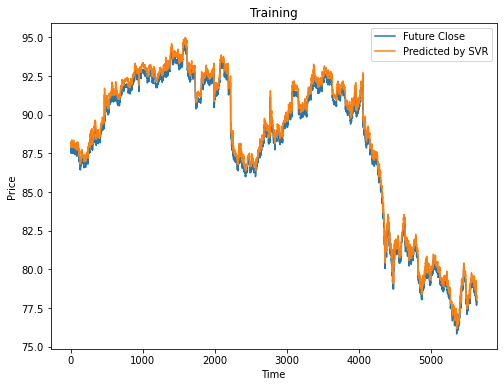

In [228]:
plt.figure(figsize=(8,6))
plt.plot(df['Future'][:split_time], label = 'Future Close')
plt.plot(df['Future_pred_SVR'][:split_time], label = 'Predicted by SVR')
plt.title('Training')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

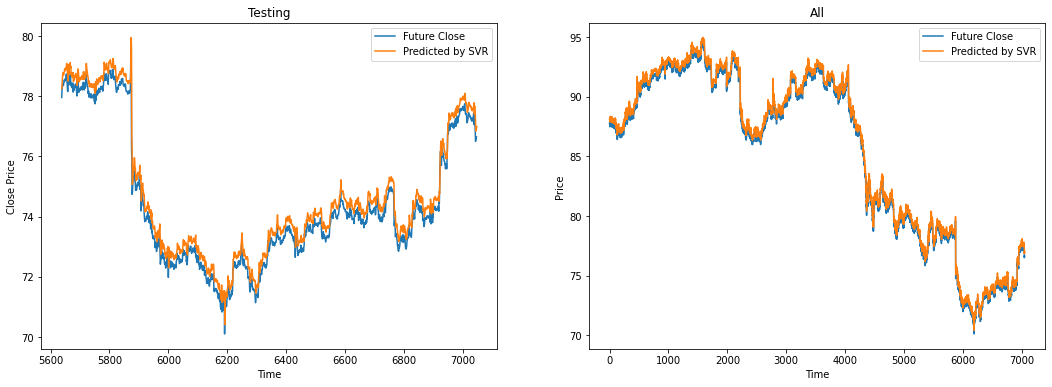

In [229]:
# %matplotlib inline
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_SVR'][split_time:], label = 'Predicted by SVR')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing')
plt.legend()

plt.subplot(1,2,2)
plt.plot(df['Future'], label = 'Future Close')
plt.plot(df['Future_pred_SVR'], label = 'Predicted by SVR')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('All')
plt.legend()

### Reference

In [50]:
svr_rbf = SVR(kernel = 'rbf', C=100, gamma = .0001)
svr_rbf.fit(x_train, y_train)
print(svr_rbf.score(x_train,y_train))

ValueError: ignored

In [38]:
print(np.array(svr_rbf.predict(x_train)))#.reshape(-1,1))
print(y_train.reshape(-1,))

[139.84715941 139.85766646 140.19964126 ... 178.55861656 178.2436105
 178.33683895]
[139.85 139.96 140.24 ... 178.62 178.33 178.42]


In [19]:
tf.keras.metrics.mean_squared_error(y_train.reshape(-1,), np.array(svr_rbf.predict(x_train))).numpy()

0.012218363654355783

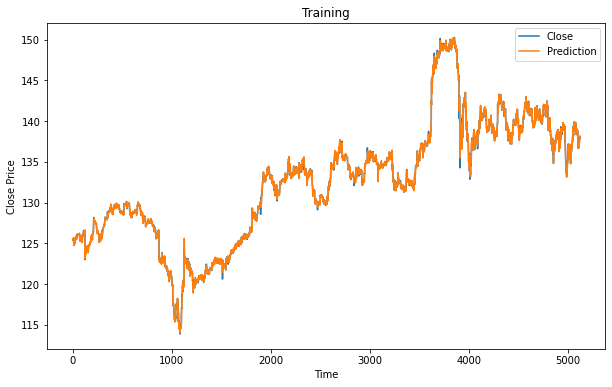

In [21]:
# plt.style.use('fivethirtyeight')
# plt.style.use('default')
plt.figure(figsize=(10,6))
plt.plot(y_train, label = 'Close')
plt.plot(svr_rbf.predict(x_train), label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Training')
plt.legend()

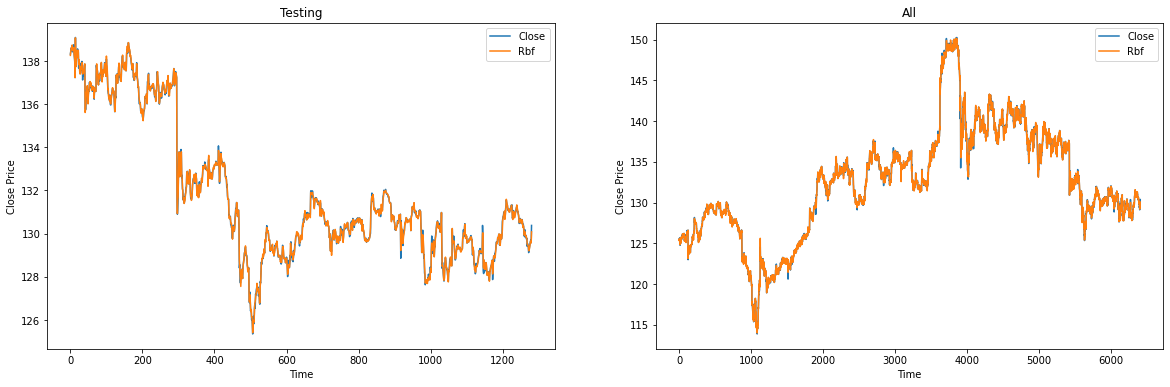

In [22]:
# %matplotlib inline
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(y_valid, label = 'Close')
plt.plot(svr_rbf.predict(x_valid), label = 'Rbf')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_data, label = 'Close')
plt.plot(svr_rbf.predict(x_data), label = 'Rbf')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('All')
plt.legend()



In [23]:
print(svr_rbf.score(x_train,y_train))
print(svr_rbf.score(x_valid,y_valid))

0.9997717211432601
0.9991538257874404


## Insights

Support vector regression gives a better prediction than the DNN with 99% accuracy when training the model, which means that there is a posibility of overfitting the data a bit. This is supported by the prediction accuracy of 93% when testing the model. This shows that the test performance of SVR model seems perfectly fitted until about time 1100 and the errors start getting greater as it goes to the future prediction.

# Neural Network
regularization l2: .01

kernel regularization max-norm: max_value=1

dropout: .5

Ne for first layer: [64, 128, 256]

learning rate: [.001, .0001]

Adam: epsilon=10e-08, beta1=.9, beta2=.999


In [40]:
print(x_train)
print(x_valid)

[[139.42 140.   139.26]
 [139.89 140.   139.1 ]
 [140.01 140.28 140.01]
 ...
 [178.54 178.66 178.54]
 [178.25 178.35 178.19]
 [178.42 178.42 178.39]]
[[178.52 178.58 178.4 ]
 [178.64 178.74 178.61]
 [178.65 178.65 178.65]
 ...
 [191.12 191.25 190.97]
 [191.21 191.21 190.44]
 [190.7  191.55 190.7 ]]


In [41]:
print(y_train.reshape(-1,1))
print(y_valid.reshape(-1,1))

[[139.85]
 [139.96]
 [140.24]
 ...
 [178.62]
 [178.33]
 [178.42]]
[[178.57]
 [178.61]
 [178.65]
 ...
 [191.21]
 [190.71]
 [190.71]]


In [0]:
x_scaler = MinMaxScaler()
x_scaler.fit(x_data)
x_data_scaled = x_scaler.transform(x_data)

y_scaler = MinMaxScaler()
y_scaler.fit(y_data.reshape(-1,1))
y_data_scaled = y_scaler.transform(y_data.reshape(-1,1))

y_train_scaled = y_data_scaled[:split_time]
x_train_scaled = x_data_scaled[:split_time,:]
y_valid_scaled = y_data_scaled[split_time:]
x_valid_scaled = x_data_scaled[split_time:,:]

In [44]:
x_data

array([[139.42, 140.  , 139.26],
       [139.89, 140.  , 139.1 ],
       [140.01, 140.28, 140.01],
       ...,
       [191.12, 191.25, 190.97],
       [191.21, 191.21, 190.44],
       [190.7 , 191.55, 190.7 ]])

In [45]:
x_scaler.inverse_transform(x_data_scaled)

array([[139.42, 140.  , 139.26],
       [139.89, 140.  , 139.1 ],
       [140.01, 140.28, 140.01],
       ...,
       [191.12, 191.25, 190.97],
       [191.21, 191.21, 190.44],
       [190.7 , 191.55, 190.7 ]])

In [30]:
!pip install -U keras-tuner

from kerastuner.tuners import RandomSearch

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [0]:
# random.seed(777)  # for reproducibility
learning_rate = 0.001
# learning_rate = [0.001, .0001]
l2_reg = .01
max_value = 1
batch_size = 100
training_epochs = 100
# nb_classes = 10
drop_rate = .5
# Ne = [64, 128, 256]
Ne = 128



tf.random.set_seed(1000)

def tuning_model(hp):
  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(Ne, input_shape=(3,), activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Dropout(drop_rate),
                               tf.keras.layers.Dense(Ne/2, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Dropout(drop_rate),
                               tf.keras.layers.Dense(Ne/4, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.Dropout(drop_rate),
                               tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')
                               ])
  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
  model.compile(loss= 'mse',
                optimizer=tf.keras.optimizers.Adam(lr=lr))#, epsilon=epsilon),#beta_1=beta1, beta_2=beta2, ),
                # metrics=['accuracy'])
  return model

MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 5
tuner = RandomSearch(
    tuning_model,
    objective='loss',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    # ,
    # directory='test_dir',
    project_name='tune_optimizer'
    # seed=RANDOM_SEED
)

In [39]:
tuner.search(x_train,y_train,epochs=2)

Epoch 1/2
161/161 [==============================] - 0s 3ms/step - loss: 17465.6953
Epoch 2/2
161/161 [==============================] - 0s 3ms/step - loss: 17418.2207
Epoch 1/2
161/161 [==============================] - 0s 2ms/step - loss: 17465.6426
Epoch 2/2
161/161 [==============================] - 0s 2ms/step - loss: 17417.8398
Epoch 1/2
161/161 [==============================] - 0s 2ms/step - loss: 17463.7988
Epoch 2/2
161/161 [==============================] - 0s 2ms/step - loss: 17421.6191
Epoch 1/2
161/161 [==============================] - 0s 2ms/step - loss: 17458.0605
Epoch 2/2
161/161 [==============================] - 0s 2ms/step - loss: 17420.6445
Epoch 1/2
161/161 [==============================] - 0s 2ms/step - loss: 17459.4746
Epoch 2/2
161/161 [==============================] - 0s 2ms/step - loss: 17428.0801


Epoch 1/2
161/161 [==============================] - 0s 3ms/step - loss: 17501.3379
Epoch 2/2
161/161 [==============================] - 0s 3ms/step - loss: 17489.3418
Epoch 1/2
161/161 [==============================] - 0s 3ms/step - loss: 17488.7598
Epoch 2/2
161/161 [==============================] - 1s 3ms/step - loss: 17477.9590
Epoch 1/2
161/161 [==============================] - 0s 2ms/step - loss: 17494.2422
Epoch 2/2
161/161 [==============================] - 0s 2ms/step - loss: 17486.0742
Epoch 1/2
161/161 [==============================] - 0s 2ms/step - loss: 17492.4629
Epoch 2/2
161/161 [==============================] - 0s 2ms/step - loss: 17484.3066
Epoch 1/2
161/161 [==============================] - 0s 2ms/step - loss: 17491.5215
Epoch 2/2
161/161 [==============================] - 0s 2ms/step - loss: 17482.7285


INFO:tensorflow:Oracle triggered exit


In [58]:
tuner.oracle.get_best_trials()[0].hyperparameters.values

{'learning_rate': 0.01}

In [48]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               512       
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

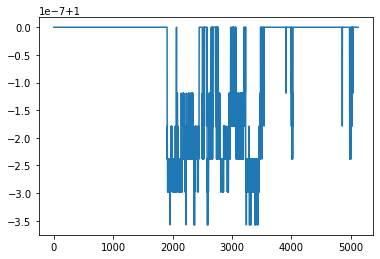

In [50]:
plt.plot(best_model.predict(x_train))

In [61]:
# random.seed(777)  # for reproducibility
learning_rate = 0.001
# learning_rate = [0.001, .0001]
l2_reg = .01
max_value = 1
batch_size = 100
training_epochs = 100
# nb_classes = 10
drop_rate = .5
# Ne = [64, 128, 256]
Ne = 128

# smote = SMOTE()
# X_train_smote, Y_train_smote = smote.fit_sample(x_train,y_train)
# X_val_smote, Y_val_smote = smote.fit_sample(x_val,y_val)


# y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
# y_test = tf.keras.utils.to_categorical(y_test, nb_classes)
tf.random.set_seed(1000)


model = tf.keras.Sequential([
                              tf.keras.layers.Dense(Ne, input_shape=(3,), activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(drop_rate),
                              tf.keras.layers.Dense(Ne/2, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(drop_rate),
                              tf.keras.layers.Dense(Ne/4, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(drop_rate),
                              tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')
                              ])
lr = 1e-2
model.compile(loss= 'mse',
              optimizer=tf.keras.optimizers.Adam(lr=lr))#, epsilon=epsilon),#beta_1=beta1, beta_2=beta2, ),
              # metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    verbose = 1,
                    epochs=training_epochs,
                    validation_data=(x_valid,y_valid)
                    )
  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               512       
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)                256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)               

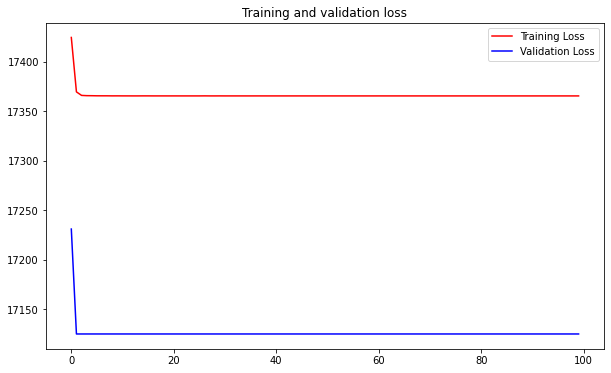

In [62]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

# plt.plot(epochs, acc, 'bo', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')

# plt.figure()

plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

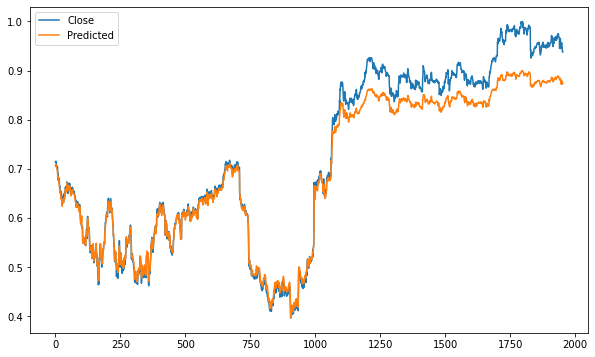

In [48]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_scaled, label = 'Close')
plt.plot(model.predict(x_valid_scaled), label = 'Predicted')
plt.legend()

# Random Forest

When the price is not observed in the training set but in the test set, the predicted price would be not correct. Therefore, the percent increase for each feature is considered to calcuate the future price percent increase and then finalize it with the predicted future price.

In [232]:
df

,Date,Symbol,Open,High,Low,Close,Volume,Future,SMA100,Tartget,Open_pch,High_pch,Low_pch,Close_pch,Volume_pch,Future_pch
0,2017-07-03 12:00:00,PG,87.79,87.79,87.72,87.74,20186,87.78,NaN,1,0.000912,0.000342,0.000114,-0.000114,-0.573343,0.000456
1,2017-07-03 12:15:00,PG,87.71,87.80,87.71,87.78,99721,87.87,NaN,1,-0.000911,0.000114,-0.000114,0.000456,3.940107,0.001025
2,2017-07-03 12:30:00,PG,87.83,87.88,87.83,87.87,79955,87.87,NaN,1,0.001368,0.000911,0.001368,0.001025,-0.198213,0.000000
3,2017-07-03 12:45:00,PG,87.89,87.90,87.87,87.87,95487,87.74,NaN,0,0.000683,0.000228,0.000455,0.000000,0.194259,-0.001479
4,2017-07-03 13:00:00,PG,87.75,87.75,87.74,87.74,460452,87.74,NaN,1,-0.001593,-0.001706,-0.001479,-0.001479,3.822143,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7043,2018-06-13 10:30:00,PG,77.04,77.04,76.10,76.83,211546,76.50,77.1782,0,-0.000778,-0.000908,-0.011688,-0.003114,0.154790,-0.004295
7044,2018-06-13 10:45:00,PG,76.74,76.76,76.47,76.50,272244,76.64,77.1856,1,-0.003894,-0.003634,0.004862,-0.004295,0.286926,0.001830
7045,2018-06-13 11:00:00,PG,76.69,76.70,76.62,76.64,115201,76.59,77.1944,0,-0.000652,-0.000782,0.001962,0.001830,-0.576847,-0.000652
7046,2018-06-13 11:15:00,PG,76.68,76.68,76.59,76.59,37918,76.65,77.2044,1,-0.000130,-0.000261,-0.000392,-0.000652,-0.670854,0.000783


In [0]:
y_data = np.array(df['Future_pch'], dtype=np.float32)
x_data = np.array(df.iloc[:,10:-1])
y_train = y_data[:split_time]
x_train = x_data[:split_time]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:]

In [234]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestRegressor(random_state=100)
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_model_cv = GridSearchCV(rf_model, param_grid=param_grid, cv=5)
rf_model_cv.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=100,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [235]:
print(rf_model_cv.best_params_)
print(rf_model_cv.best_score_)

{'max_features': 'auto', 'n_estimators': 100}
-0.08206497722155807


In [236]:
rf_model = RandomForestRegressor().set_params(**rf_model_cv.best_params_)
rf_model.fit(x_train,y_train)

df['Future_pch_predicted_RF'] = rf_model.predict(x_data)
df['Future_pred_RF'] = df['Future_pch_predicted_RF'] * df['Close'] + df['Close']

from sklearn.metrics import mean_squared_error

print('R squared coeff for whole data: {}'.format(rf_model.score(x_data,y_data)))
print('R squared coeff for train data: {}'.format(rf_model.score(x_train,y_train)))
print('R squared coeff for test data: {}'.format(rf_model.score(x_valid,y_valid)))
print('------------------------------------')
print('Mean squared error: {}'.format(mean_squared_error(df['Future'].to_numpy()[:-1],df['Future_pred_RF'].to_numpy()[:-1])))

R squared coeff for whole data: 0.5962026697023719
R squared coeff for train data: 0.8367388254304964
R squared coeff for test data: -0.11077225059579776
------------------------------------
Mean squared error: 0.008968818061331535


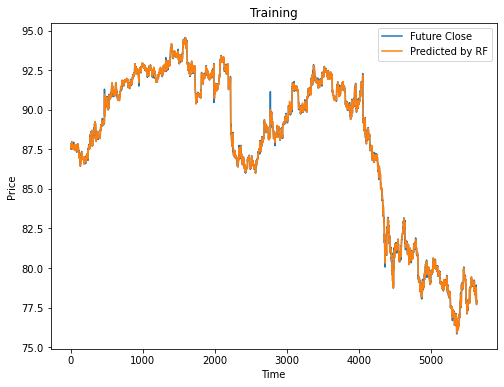

In [237]:
plt.figure(figsize=(8,6))
plt.plot(df['Future'][:split_time], label = 'Future Close')
plt.plot(df['Future_pred_RF'][:split_time], label = 'Predicted by RF')
plt.title('Training')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

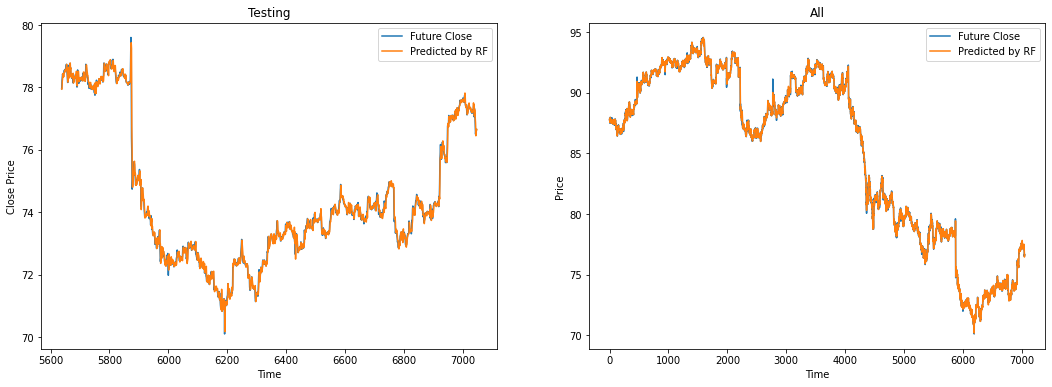

In [238]:
# %matplotlib inline
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(df['Future'][split_time:], label = 'Future Close')
plt.plot(df['Future_pred_RF'][split_time:], label = 'Predicted by RF')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing')
plt.legend()

plt.subplot(1,2,2)
plt.plot(df['Future'], label = 'Future Close')
plt.plot(df['Future_pred_RF'], label = 'Predicted by RF')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('All')
plt.legend()

In [180]:
df

,Date,Symbol,Open,High,Low,Close,Volume,Future,SMA100,Tartget,Open_pch,High_pch,Low_pch,Close_pch,Volume_pch,Future_pch,Future_pch_predicted_RF,Future_pred_RF
0,2017-07-03 12:00:00,PG,87.79,87.79,87.72,87.74,20186,87.78,NaN,1,0.000912,0.000342,0.000114,-0.000114,-0.573343,0.000456,0.000622,87.794571
1,2017-07-03 12:15:00,PG,87.71,87.80,87.71,87.78,99721,87.87,NaN,1,-0.000911,0.000114,-0.000114,0.000456,3.940107,0.001025,0.000690,87.840564
2,2017-07-03 12:30:00,PG,87.83,87.88,87.83,87.87,79955,87.87,NaN,1,0.001368,0.000911,0.001368,0.001025,-0.198213,0.000000,0.000446,87.909224
3,2017-07-03 12:45:00,PG,87.89,87.90,87.87,87.87,95487,87.74,NaN,0,0.000683,0.000228,0.000455,0.000000,0.194259,-0.001479,-0.001131,87.770587
4,2017-07-03 13:00:00,PG,87.75,87.75,87.74,87.74,460452,87.74,NaN,1,-0.001593,-0.001706,-0.001479,-0.001479,3.822143,0.000000,0.000333,87.769260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7043,2018-06-13 10:30:00,PG,77.04,77.04,76.10,76.83,211546,76.50,77.1782,0,-0.000778,-0.000908,-0.011688,-0.003114,0.154790,-0.004295,-0.001404,76.722145
7044,2018-06-13 10:45:00,PG,76.74,76.76,76.47,76.50,272244,76.64,77.1856,1,-0.003894,-0.003634,0.004862,-0.004295,0.286926,0.001830,0.001379,76.605476
7045,2018-06-13 11:00:00,PG,76.69,76.70,76.62,76.64,115201,76.59,77.1944,0,-0.000652,-0.000782,0.001962,0.001830,-0.576847,-0.000652,-0.001727,76.507659
7046,2018-06-13 11:15:00,PG,76.68,76.68,76.59,76.59,37918,76.65,77.2044,1,-0.000130,-0.000261,-0.000392,-0.000652,-0.670854,0.000783,0.000571,76.633725


### Reference

In [0]:
CV_rfc.best_params_

In [66]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=100)
param_grid = {
    'n_estimators': [200,400,600],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4,5,6,7,8]
}
rf_model_cv = GridSearchCV(rf_model, param_grid=param_grid, cv=5)
rf_model_cv.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=100,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [71]:
rf_model = RandomForestRegressor().set_params(**rf_model_cv.best_params_)
rf_model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [77]:
print(rf_model.score(x_train,y_train))
print(rf_model.score(x_valid,y_valid))

0.9998417881636115
0.9985131689031406


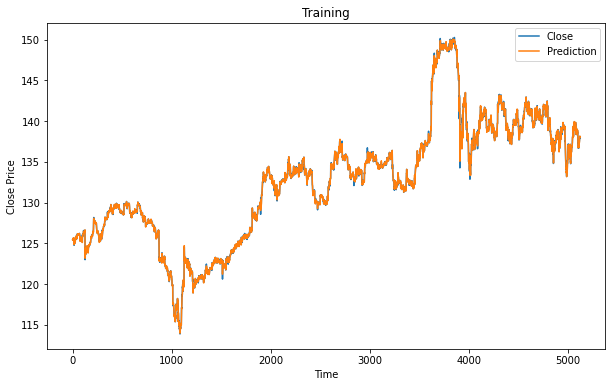

In [78]:
plt.figure(figsize=(10,6))
plt.plot(y_train, label = 'Close')
plt.plot(rf_model.predict(x_train), label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Training')
plt.legend()

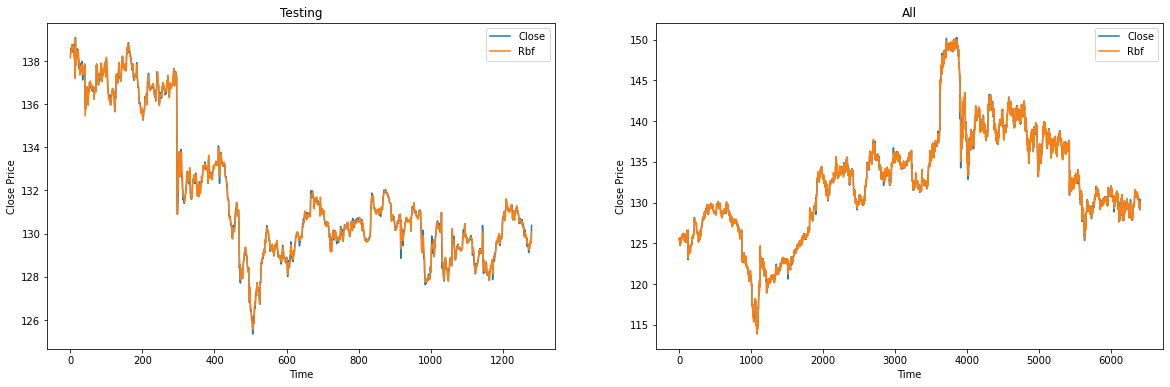

In [79]:
# %matplotlib inline
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(y_valid, label = 'Close')
plt.plot(rf_model.predict(x_valid), label = 'Rbf')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_data, label = 'Close')
plt.plot(rf_model.predict(x_data), label = 'Rbf')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('All')
plt.legend()

In [6]:
import json

movie = "[{'id': 13, 'name': 'ae'}, {'id': 16, 'name': 'Animation'}]".replace('\'','"')

json.loads(movie)

[{'id': 13, 'name': 'ae'}, {'id': 16, 'name': 'Animation'}]

In [7]:
for j in json.loads(movie):
  print(j['id'])

13
16


# Buy Sell Indicator

In [0]:
def buy_sell(data):
  signal_buy = []
  signal_sell = []
  flag = -1
  for i in range(len(data)):
    if data['SMA30'][i] > data['SMA100'][i]:
      if flag != 1:
        signal_buy.append(data['AAPL'][i])
        signal_sell.append(np.nan)
        flag = 1
      else:
        signal_buy.append(np.nan)
        signal_sell.append(np.nan)
    elif data['SMA30'][i] < data['SMA100'][i]:
      if flag != 0:
        signal_buy.append(np.nan)
        signal_sell.append(data['AAPL'][i])
        flag = 0
      else:
        signal_buy.append(np.nan)
        signal_sell.append(np.nan)
    else:
      signal_buy.append(np.nan)
      signal_sell.append(np.nan)
  
  return signal_buy, signal_sell

buy_sell_data = buy_sell(data)
data['Buy signal'] = buy_sell_data[0]
data['Sell signal'] = buy_sell_data[1]

# Clean Up
Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

# Reference


https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79